In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import train, validate, patched_forward
from scripts.utils import CombinedLoss
from models.unet import UNet3D
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from monai.networks.nets import SwinUNETR

from scripts.dataset import TrainDataset, TestDataset

In [3]:
train_image_path = 'data/Task02_Heart/imagesTr'
train_label_path = 'data/Task02_Heart/labelsTr'
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 64, 64)
train_dataset = TrainDataset(train_image_path, train_label_path, patch_size, require_target=0.75, preload_all_images=True, num_patches_per_image=2)
val_dataset = TestDataset(val_image_path, val_label_path)

batch_size = 4
# The effective batch size will be batch_size * num_patches_per_image
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [4]:
model = SwinUNETR(in_channels=1, out_channels=1, img_size=(64 , 64 , 64), use_checkpoint=True)

loss_fn = CombinedLoss(smooth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 1000
validation_freq = 50

results = train(model, optimizer, loss_fn, train_loader, val_loader, None, device, epochs, patch_size=patch_size, validation_freq=validation_freq)

/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Starting training on device cuda...


/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv3d(


Epoch 1 of 1000 took 3.71s | Training: loss=1.8630, iou=0.0358, dice=0.0692
Epoch 2 of 1000 took 3.14s | Training: loss=1.7454, iou=0.0454, dice=0.0861
Epoch 3 of 1000 took 3.14s | Training: loss=1.6515, iou=0.0665, dice=0.1243
Epoch 4 of 1000 took 3.14s | Training: loss=1.6208, iou=0.0553, dice=0.1049
Epoch 5 of 1000 took 3.11s | Training: loss=1.5643, iou=0.0588, dice=0.1108
Epoch 6 of 1000 took 3.09s | Training: loss=1.5370, iou=0.0543, dice=0.1022
Epoch 7 of 1000 took 3.10s | Training: loss=1.5492, iou=0.0466, dice=0.0884
Epoch 8 of 1000 took 3.09s | Training: loss=1.5073, iou=0.1023, dice=0.1851
Epoch 9 of 1000 took 3.11s | Training: loss=1.4942, iou=0.1248, dice=0.2165
Epoch 10 of 1000 took 3.13s | Training: loss=1.4453, iou=0.1907, dice=0.3163
Epoch 11 of 1000 took 3.15s | Training: loss=1.4754, iou=0.1580, dice=0.2718
Epoch 12 of 1000 took 3.16s | Training: loss=1.4583, iou=0.1507, dice=0.2546
Epoch 13 of 1000 took 3.16s | Training: loss=1.4819, iou=0.1510, dice=0.2552
Epoch 14

In [5]:
file_name = 'swinUnetR_model_results.pkl'

# Check if 'results' exists in the local scope
if 'results' in locals():
    # Unpack and save the model's state dict and results
    with open(file_name, 'wb') as f:
        pickle.dump({
            'model_state': results[0].state_dict(),  # best_model state dict
            'train_metrics': results[1],  # results_train
            'val_metrics': results[2]    # results_val
        }, f)
    print(f"Results and model saved to {file_name}")

else:
    # Load the results and model state from the file
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        best_model = SwinUNETR(in_channels=1, out_channels=1, img_size=(64 , 64 , 64))

        best_model.load_state_dict(data['model_state'])
        results = (best_model, data['train_metrics'], data['val_metrics'])
    print(f"Results and model loaded from {file_name}")

best_model, results_train, results_val = results

Results and model saved to swinunetR_model_rmujnnuniiunesults.pkl


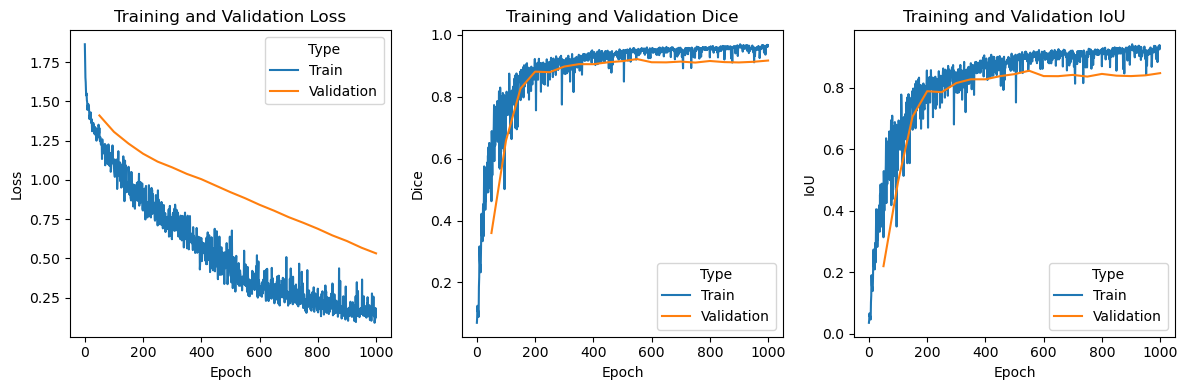

In [6]:
# Create DataFrames for easier plotting with Seaborn
df_train_loss = pd.DataFrame({'Epoch': range(len(results_train['loss'])), 'Value': results_train['loss'], 'Metric': 'Loss', 'Type': 'Train'})
df_val_loss = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['loss']))], 'Value': results_val['loss'], 'Metric': 'Loss', 'Type': 'Validation'})

df_train_dice = pd.DataFrame({'Epoch': range(len(results_train['dice'])), 'Value': results_train['dice'], 'Metric': 'Dice', 'Type': 'Train'})
df_val_dice = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['dice']))], 'Value': results_val['dice'], 'Metric': 'Dice', 'Type': 'Validation'})

df_train_iou = pd.DataFrame({'Epoch': range(len(results_train['iou'])), 'Value': results_train['iou'], 'Metric': 'IoU', 'Type': 'Train'})
df_val_iou = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['iou']))], 'Value': results_val['iou'], 'Metric': 'IoU', 'Type': 'Validation'})

# Combine the DataFrames
df = pd.concat([df_train_loss, df_val_loss, df_train_dice, df_val_dice, df_train_iou, df_val_iou])

# Plot using Seaborn
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df[df['Metric'] == 'Loss'], x='Epoch', y='Value', hue='Type', ax=axs[0])
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

sns.lineplot(data=df[df['Metric'] == 'Dice'], x='Epoch', y='Value', hue='Type', ax=axs[1])
axs[1].set_title('Training and Validation Dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice')

sns.lineplot(data=df[df['Metric'] == 'IoU'], x='Epoch', y='Value', hue='Type', ax=axs[2])
axs[2].set_title('Training and Validation IoU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('IoU')

plt.tight_layout()
plt.show()

In [7]:
image, label = val_dataset[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    pred_logits = patched_forward(best_model, image, patch_size, 'cuda')
pred = torch.sigmoid(pred_logits)
pred = pred.squeeze(0, 1)
image = image.squeeze(0, 1)

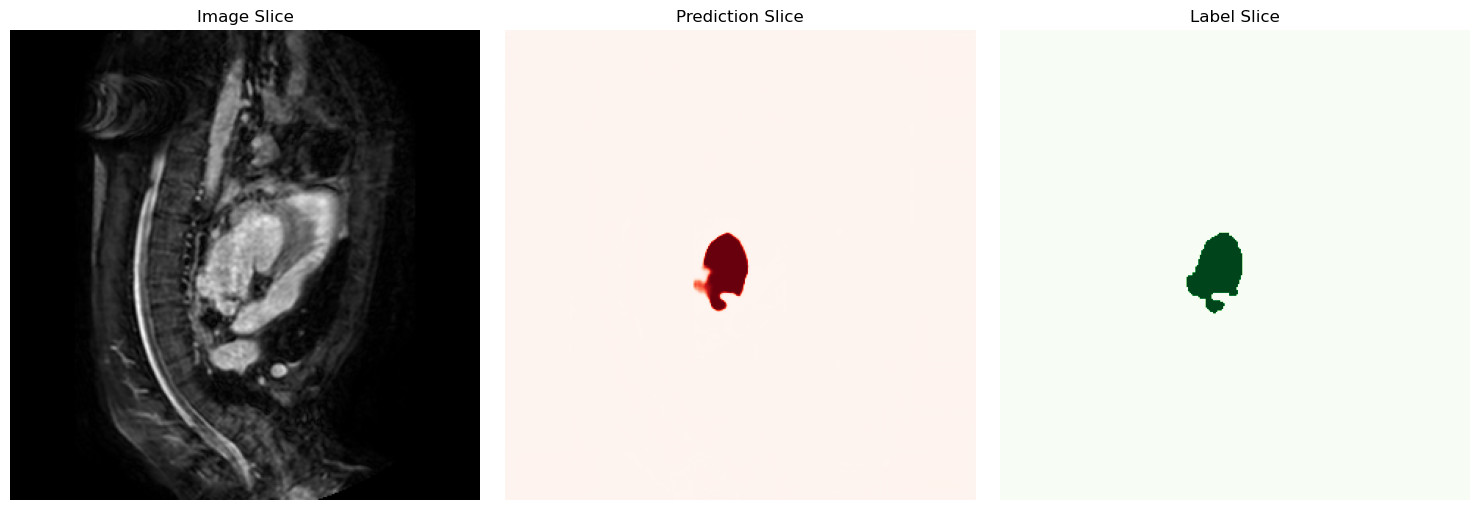

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 50

image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Create the figure and the axes with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image slice
axs[0].imshow(image_slice, cmap='gray')
axs[0].set_title('Image Slice')
axs[0].axis('off')

# Plot the prediction slice
axs[1].imshow(pred_slice, vmin=0, vmax=1, cmap='Reds')
axs[1].set_title('Prediction Slice')
axs[1].axis('off')

# Plot the label slice
axs[2].imshow(label_slice, cmap='Greens')
axs[2].set_title('Label Slice')
axs[2].axis('off')

# Display the figure
plt.tight_layout()
plt.show()


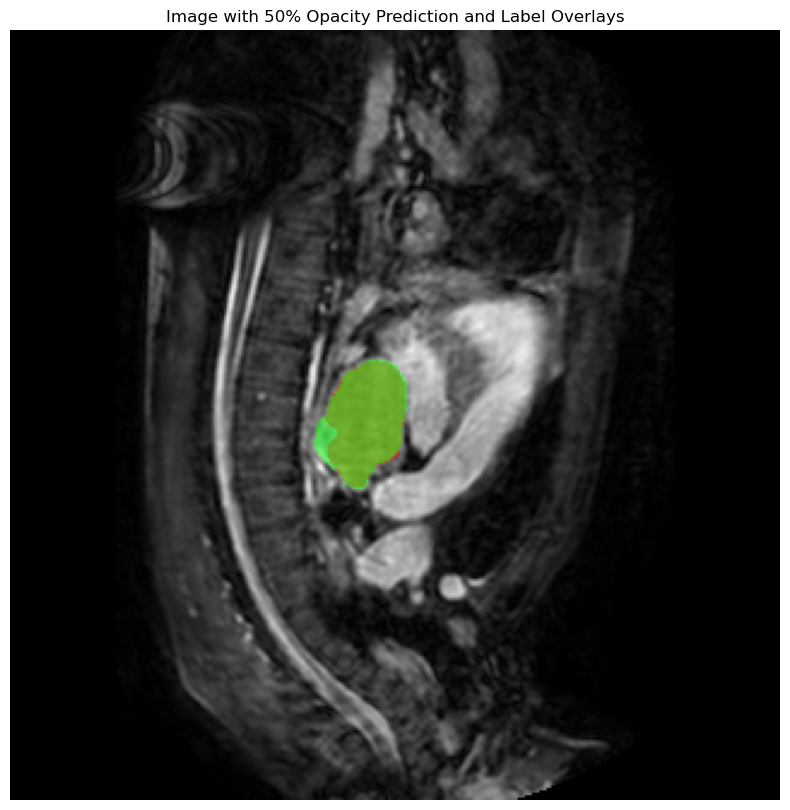

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 50
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

pred_slice = (pred_slice > 0.5).astype(np.float32)

# Normalize image slice for visualization (if needed)
image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

# Create an RGB image from the grayscale slice
image_rgb = np.stack([image_slice]*3, axis=-1)

# Create solid colors for the prediction and label overlays
red_overlay = np.zeros_like(image_rgb)
red_overlay[..., 0] = 1  # Red color for prediction

green_overlay = np.zeros_like(image_rgb)
green_overlay[..., 1] = 1  # Green color for label

# Create the prediction and label masks (expanding dims for compatibility)
pred_mask = np.expand_dims(pred_slice, axis=-1)
label_mask = np.expand_dims(label_slice, axis=-1)

# Set the opacity for the overlays (50% opacity)
opacity = 0.5

# Blend the solid color with the original image using the mask
# First, apply the red overlay for predictions
overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity

# Then, apply the green overlay for labels
overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity

# Plot the resulting image with the 50% opacity overlays
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title('Image with 50% Opacity Prediction and Label Overlays')
plt.axis('off')
plt.show()
